This project uses the News Headlines Dataset for Sarcasm Detection.
First, we'll import the libraries and dataset from the json file.

In [79]:
import numpy as np
import pandas as pd
import re
import nltk
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud


data = pd.read_json("Sarcasm_Headlines_Dataset.json",lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


The data contains the source, headline, and binary value indicating sarcasm.
Get the sarcastic values and headlines out of the json format in a usable format.
Then, tokenize to split up the array of strings into words and put them in a usable format.

In [80]:
sarcastic_data = data.is_sarcastic.values
titles         = data.headline.values

from nltk import word_tokenize

titles_tokenized    = [] #defining arrays
titles_words_only   = []
titles_stem         = []
word_list           = []
print(titles[0])
for title in titles: #tokenize titles
    titles_tokenized.append(word_tokenize(title))
print(titles_tokenized[0])
for title in titles_tokenized: #gets rid of things like apostrophes
    words = [word for word in title if word.isalpha()]
    titles_words_only.append(words)
print(titles_words_only[0]) #this should not have taken out the word black but it did?
porter = PorterStemmer() #reducing words to word's root form
for title in titles_words_only:
    stemmed = [porter.stem(word) for word in title]
    titles_stem.append(stemmed)
print(titles_stem[0])
for title in titles_stem: #turning list of lists into one list of strings
    for word in title:
        word_list.append(word)
print(word_list[0]) #since 1d array, first elem only first word

former versace store clerk sues over secret 'black code' for minority shoppers
['former', 'versace', 'store', 'clerk', 'sues', 'over', 'secret', "'black", 'code', "'", 'for', 'minority', 'shoppers']
['former', 'versace', 'store', 'clerk', 'sues', 'over', 'secret', 'code', 'for', 'minority', 'shoppers']
['former', 'versac', 'store', 'clerk', 'sue', 'over', 'secret', 'code', 'for', 'minor', 'shopper']
former


Count the number of occurrances of each word.
Pull out the first 10000 most common words, and 

In [81]:
freq_list = Counter(word_list)

In [82]:
dictionary = freq_list.most_common(10000) #putting the most common words in our dictionary
dictionary = list(zip(*dictionary))[0] #don't need the frequencies anymore
print(dictionary)
nums = range(0,10000)
word_int = dict(zip(dictionary, nums))

('to', 'of', 'the', 'in', 'for', 'a', 'on', 'and', 'with', 'is', 'trump', 'new', 'man', 'from', 'at', 'it', 'you', 'about', 'be', 'thi', 'by', 'after', 'that', 'how', 'out', 'he', 'as', 'up', 'get', 'not', 'say', 'are', 'what', 'report', 'your', 'hi', 'make', 'who', 'ha', 'have', 'just', 'will', 'more', 'all', 'one', 'day', 'do', 'into', 'nation', 'whi', 'i', 'area', 'year', 'time', 'over', 'woman', 'american', 'donald', 'like', 'can', 'obama', 'take', 'first', 'her', 'women', 'peopl', 'way', 'no', 'world', 'show', 'hous', 'an', 'thing', 'go', 'now', 'find', 'call', 'wa', 'we', 'life', 'off', 'look', 'clinton', 'want', 'back', 'still', 'they', 'than', 'white', 'famili', 'my', 'watch', 'could', 'down', 'plan', 'live', 'if', 'work', 'state', 'know', 'when', 'use', 'need', 'love', 'school', 'doe', 'she', 'come', 'right', 'should', 'their', 'kill', 'befor', 'presid', 'chang', 'mom', 'gop', 'parent', 'studi', 'think', 'give', 'would', 'kid', 'bill', 'most', 'black', 'here', 'talk', 'friend'

In [83]:
y_data = sarcastic_data
x_data = []

for title in titles_stem:
    x_data.append([word_int[x] for x in title if x in word_int.keys()])

x = np.array(x_data)
test_data = x[:5000]
train_data = x[5000:]

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

from keras.utils.np_utils import to_categorical

y = np.asarray(y_data).astype('float32')

#split data into testing and training data
y_test = y[:5000]
y_train = y[5000:]

x_data = x_train[:5000]
x_half_train = x_train[5000:]

y_data = y_train[:5000]
y_half_train = y_train[5000:]

Building the model continuously while adding each layer:

In [84]:
from keras import models
from keras import layers

model = models.Sequential()
#32 neurons added to the first layer
model.add(layers.Dense(32, activation='relu', input_shape = (10000,)))
print("1st layer weights:",len(model.weights))
#4 neurons added to the second layer
model.add(layers.Dense(4, activation='relu'))
print("2nd layer weights:",len(model.weights))
#neuron added to the last layer and 
model.add(layers.Dense(1, activation = 'softmax'))
print("3rd layer weights:",len(model.weights))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(x_half_train, y_half_train, epochs = 25, batch_size = 300, validation_data=(x_data, y_data))

1st layer weights: 2
2nd layer weights: 4
3rd layer weights: 6
Epoch 1/25
56/56 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - accuracy: 0.4381 - val_loss: 0.0000e+00 - val_accuracy: 0.4516
Epoch 2/25
56/56 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.4356 - val_loss: 0.0000e+00 - val_accuracy: 0.4516
Epoch 3/25
56/56 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.4326 - val_loss: 0.0000e+00 - val_accuracy: 0.4516
Epoch 4/25
56/56 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 0.4371 - val_loss: 0.0000e+00 - val_accuracy: 0.4516
Epoch 5/25
56/56 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.4334 - val_loss: 0.0000e+00 - val_accuracy: 0.4516
Epoch 6/25
56/56 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4390 - val_loss: 0.0000e+00 - val_accuracy: 0.4516
Epoch 7/25
56/56 [==========================

In [85]:
results = model.evaluate(x_test, y_test)

results

157/157 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.4374


[0.0, 0.4374000132083893]

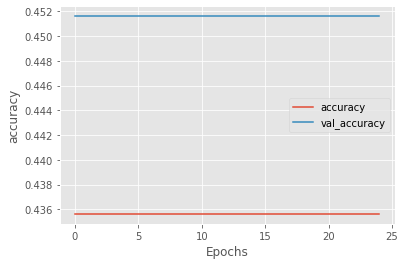

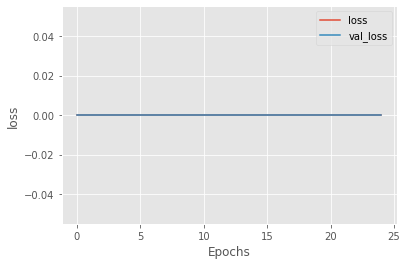

In [86]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

This model could be improved, so let's change the hyperparamters.

In [87]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape = (10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation = 'softmax'))
#this time instead of optimizer 'adam', we use rmsprop, and loss 'categorical' to "binary"
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [88]:
#larger batch size from 30 to 410
history = model.fit(x_half_train, y_half_train, epochs = 25, batch_size = 410, validation_data=(x_data, y_data))

Epoch 1/25
41/41 [==============================] - 1s 20ms/step - loss: 0.6512 - accuracy: 0.4371 - val_loss: 0.5314 - val_accuracy: 0.4516
Epoch 2/25
41/41 [==============================] - 1s 14ms/step - loss: 0.4733 - accuracy: 0.4306 - val_loss: 0.4270 - val_accuracy: 0.4516
Epoch 3/25
41/41 [==============================] - 1s 13ms/step - loss: 0.3614 - accuracy: 0.4397 - val_loss: 0.3779 - val_accuracy: 0.4516
Epoch 4/25
41/41 [==============================] - 1s 14ms/step - loss: 0.2944 - accuracy: 0.4384 - val_loss: 0.3602 - val_accuracy: 0.4516
Epoch 5/25
41/41 [==============================] - 1s 14ms/step - loss: 0.2507 - accuracy: 0.4395 - val_loss: 0.3572 - val_accuracy: 0.4516
Epoch 6/25
41/41 [==============================] - 1s 14ms/step - loss: 0.2177 - accuracy: 0.4395 - val_loss: 0.3649 - val_accuracy: 0.4516
Epoch 7/25
41/41 [==============================] - 1s 13ms/step - loss: 0.1956 - accuracy: 0.4312 - val_loss: 0.3724 - val_accuracy: 0.4516
Epoch 8/25
41

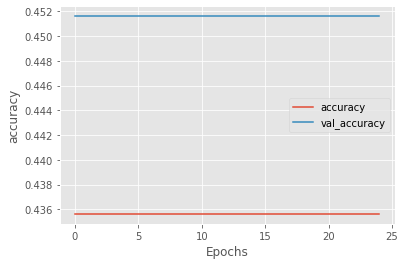

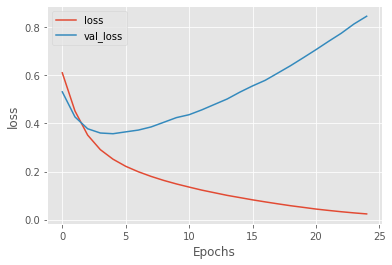

In [89]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [90]:
results = model.evaluate(x_test, y_test)
results

157/157 [==============================] - 0s 1ms/step - loss: 0.8533 - accuracy: 0.4374


[0.8532740473747253, 0.4374000132083893]

The model is better, but not great. Let's make the activation function sigmoid instead of softmax.


In [91]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape = (10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [92]:
history = model.fit(x_half_train, y_half_train, epochs = 10, batch_size = 512, validation_data=(x_data, y_data))

Epoch 1/10
33/33 [==============================] - 2s 28ms/step - loss: 0.6616 - accuracy: 0.6886 - val_loss: 0.5688 - val_accuracy: 0.8264
Epoch 2/10
33/33 [==============================] - 1s 16ms/step - loss: 0.5216 - accuracy: 0.8612 - val_loss: 0.4688 - val_accuracy: 0.8408
Epoch 3/10
33/33 [==============================] - 1s 16ms/step - loss: 0.4121 - accuracy: 0.8795 - val_loss: 0.4055 - val_accuracy: 0.8428
Epoch 4/10
33/33 [==============================] - 1s 16ms/step - loss: 0.3343 - accuracy: 0.8922 - val_loss: 0.3722 - val_accuracy: 0.8444
Epoch 5/10
33/33 [==============================] - 1s 16ms/step - loss: 0.2837 - accuracy: 0.9036 - val_loss: 0.3582 - val_accuracy: 0.8454
Epoch 6/10
33/33 [==============================] - 1s 16ms/step - loss: 0.2556 - accuracy: 0.9097 - val_loss: 0.3559 - val_accuracy: 0.8462
Epoch 7/10
33/33 [==============================] - 0s 14ms/step - loss: 0.2183 - accuracy: 0.9214 - val_loss: 0.3608 - val_accuracy: 0.8436
Epoch 8/10
33

157/157 [==============================] - 0s 1ms/step - loss: 0.3972 - accuracy: 0.8360


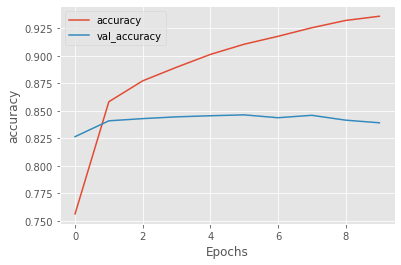

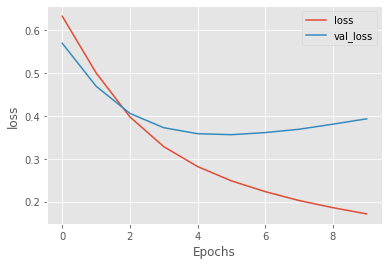

In [93]:
results = model.evaluate(x_test, y_test)
results

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

This model is the most accurate thus far.

In [54]:
stops=stopwords.words("english") #install stopwords with nltk.download()

corpus=[]

for i in range(data.shape[0]):
    headline = re.sub("[^a-zA-Z]"," ",data["headline"][i] )
    headline=headline.lower()
    headline=headline.split()
    ps=PorterStemmer()
    headline=[ps.stem(word) for word in headline if not word in set(stops)]
    headline='  '.join(headline)
    corpus.append(headline)

corpus

['former  versac  store  clerk  sue  secret  black  code  minor  shopper',
 'roseann  reviv  catch  thorni  polit  mood  better  wors',
 'mom  start  fear  son  web  seri  closest  thing  grandchild',
 'boehner  want  wife  listen  come  altern  debt  reduct  idea',
 'j  k  rowl  wish  snape  happi  birthday  magic  way',
 'advanc  world  women',
 'fascin  case  eat  lab  grown  meat',
 'ceo  send  kid  school  work  compani',
 'top  snake  handler  leav  sink  huckabe  campaign',
 'friday  morn  email  insid  trump  presser  age',
 'airlin  passeng  tackl  man  rush  cockpit  bomb  threat',
 'facebook  reportedli  work  healthcar  featur  app',
 'north  korea  prais  trump  urg  us  voter  reject  dull  hillari',
 'actual  cnn  jeffrey  lord  indefens',
 'barcelona  hold  huge  protest  support  refuge',
 'nuclear  bomb  deton  rehears  spider  man  music',
 'cosbi  lawyer  ask  accus  come  forward  smear  legal  team  year  ago',
 'stock  analyst  confus  frighten  boar  market',
 '

No of Non-Sarcastic news:  14985
No of Sarcastic news:  11724


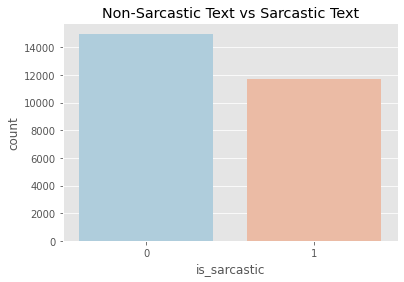

In [94]:
%matplotlib inline
plt.style.use('ggplot')

#Non-sarcastic vs Sarcastic
x = data['is_sarcastic']
sns.countplot(x=x,palette="RdBu_r")
x = "Non-Sarcastic Text vs Sarcastic Text"
plt.title(x)
x = "No of Non-Sarcastic news: "
y = data['is_sarcastic'].value_counts()[0]
print(x,y)
x ="No of Sarcastic news: "
y = data['is_sarcastic'].value_counts()[1]
print(x,y)


<AxesSubplot:title={'center':'Sarcastic Text'}, xlabel='headline', ylabel='Count'>

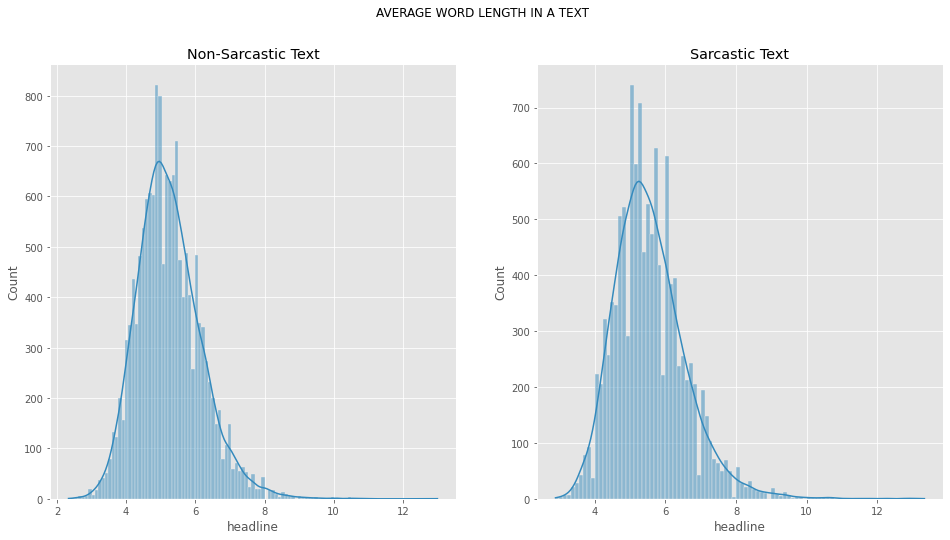

In [95]:
#Check the average length of recurrent words
fig,ax = plt.subplots(figsize=(16,8))
fig.suptitle("AVERAGE WORD LENGTH IN A TEXT")

plt.subplot(1,2,1)
plt.title("Non-Sarcastic Text")
word_length = data[data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x] )
sns.histplot(word_length.map(lambda x: np.mean(x)),kde=True)

plt.subplot(1,2,2)
plt.title("Sarcastic Text")
word_length = data[data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x] )
sns.histplot(word_length.map(lambda x: np.mean(x)),kde=True)